In [4]:
import pandas as pd
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
import sklearn
from sklearn.linear_model import LinearRegression 
from scipy.stats import zscore
import warnings
from scipy.spatial.distance import pdist,squareform
from mpl_toolkits.basemap import Basemap
import re


The first step is to read the csv file containing the country data , analyse it and clean it( if necessary) 

In [2]:
warnings.filterwarnings('ignore')
df = pd.read_csv('../data.csv')
%matplotlib inline

In [3]:
df

,Country Name,Country Code,Government Type,Capital City,Date of Founding/Independence,Latitude of Capital,Longitude of Capital,Population,Life Expectancy,GDP (PPP) in US $,...,Land Boundaries (km),Coastline (km),Literacy Rate (%),Health Expenditure/GDP,Military Expenditure/GDP,Renewable Water Resources (cu km),Net Migration Rate/1000 Population,Labor Force,Internet Users (circa 2009),Commercial Prime Lending Rate
0,Afghanistan,AF,Islamic republic,Kabul,8/19/19,34 31 N,69 11 E,31822848,50.49,4.530000e+10,...,5987.0,0.0,28.1,9.6,4.74,65.33,-1.83,7512000,1000000,15
1,Albania,AL,parliamentary democracy,Tirana,11/28/12,41 19 N,19 49 E,3020209,77.96,2.834000e+10,...,691.0,362.0,96.8,6.3,1.47,41.7,-3.31,1098000,1300000,9.52
2,Algeria,DZ,republic,Algiers,7/5/62,36 45 N,3 03 E,38813722,76.39,2.850000e+11,...,6734.0,998.0,72.6,3.9,4.48,11.67,-0.93,11150000,4700000,8
3,Andorra,AD,parliamentary democracy,Andorra la Vella,1278,42 30 N,1 31 E,85458,82.65,3.163000e+09,...,118.0,0.0,100,7.2,unknown,unknown,0,36060,67100,unknown
4,Angola,AO,republic,Luanda,11/11/75,8 50 S,13 13 E,19088106,55.29,1.320000e+11,...,5369.0,1600.0,70.4,3.5,3.63,148,0.47,9018000,606700,15
5,Antigua and Barbuda,AG,constitutional monarchy,Saint John's,11/1/81,17 07 N,61 51 W,91295,76.12,1.610000e+09,...,0.0,153.0,99,5.9,unknown,0.05,2.23,30000,65000,10.3
6,Argentina,AR,republic,Buenos Aires,7/9/1816,34 35 S,58 40 W,43024374,77.51,7.710000e+11,...,11968.0,4989.0,97.9,8.1,0.91,814,0,17320000,13694000,16.4
7,Armenia,AM,republic,Yerevan,9/21/91,40 10 N,44 30 E,3060631,74.12,2.061000e+10,...,1570.0,0.0,99.6,4.3,3.92,7.77,-5.88,1394000,208200,16.5
8,Australia,AU,federal parliamentary democracy,Canberra,1/1/01,35 16 S,149 08 E,22507617,82.07,9.980000e+11,...,0.0,25760.0,99,9,1.71,492,5.74,12440000,15810000,6.2
9,Austria,AT,federal republic,Vienna,11/12/18,48 12 N,16 22 E,8223062,80.17,3.610000e+11,...,2524.0,0.0,98,10.6,0.81,77.7,1.76,3737000,6143000,2.2


We need to identify the relevant columns with numerical values that we will be analysing in the subsequent questions. 

In [183]:
df.dtypes

Country Name                           object
Country Code                           object
Government Type                        object
Capital City                           object
Date of Founding/Independence          object
Latitude of Capital                    object
Longitude of Capital                   object
Population                              int64
Life Expectancy                       float64
GDP (PPP) in US $                     float64
Area (sq km)                          float64
Land Boundaries (km)                  float64
Coastline (km)                        float64
Literacy Rate (%)                      object
Health Expenditure/GDP                 object
Military Expenditure/GDP               object
Renewable Water Resources (cu km)      object
Net Migration Rate/1000 Population     object
Labor Force                            object
Internet Users (circa 2009)            object
Commercial Prime Lending Rate          object
dtype: object

Now here we see that some of the columns containing numerical values are of object type such as Literacy Rate (%) , Health Expenditure ,etc. Also, some of the values in these columns are 'unknown' . So we change the data type of these columns and replace these unknown values with their mean. 

In [184]:
df = df.replace('unknown','NaN')
df_new = df[['Literacy Rate (%)','Health Expenditure/GDP','Military Expenditure/GDP','Renewable Water Resources (cu km)',
             'Net Migration Rate/1000 Population','Labor Force','Internet Users (circa 2009)',
             'Commercial Prime Lending Rate']]
df_new = df_new.astype(float)
df_new = df_new.fillna(df_new.mean())

array_to_del =['Literacy Rate (%)','Health Expenditure/GDP','Military Expenditure/GDP',
               'Renewable Water Resources (cu km)','Net Migration Rate/1000 Population','Labor Force',
               'Internet Users (circa 2009)','Commercial Prime Lending Rate']

for col in df.columns:
    if col in array_to_del:
        del df[col]

df = pd.concat([df,df_new],axis=1)

Some columns such as Land Boundaries and Coastline contain 0 values. Since log10(0) is undefined , these values will result in errors in our linear regression graphs (which are plotted in log scale below). Hence we need to process these 0 values depending on their column type. These are described below

In [185]:
def changeValues(df,column_name,Value):    
    df.rename(columns = {column_name:'Temp_Name'}, inplace = True)
    df.ix[df.Temp_Name == 0, 'Temp_Name'] = Value
    df.rename(columns = {'Temp_Name':column_name}, inplace = True)

'Land boundaries (km)'- We know that the land area of any country cannot be 0. Hence 0 in this column highlights missing values. So we replace 0 values in this column with its mean value. 

In [186]:
changeValues(df,'Land Boundaries (km)',df['Land Boundaries (km)'].mean())

'Coastline (km)'- Some values in this column are 0 . Now a land locked country can have 0 as the coastline value. Or it can also be a missing value. We don't know this . Hence we do not want to replace the 0 values in this column with their mean as a lot of land locked countries will then have wrong values. So we choose to replace the 0 values with 0.01 (which is as good as 0 only). 

'Military Expenditure/GDP'- Some values in this column are 0 . Similar to the Coastline column, we replace these values with a small value 0.01.

In [187]:
changeValues(df,'Coastline (km)',0.01)
changeValues(df,'Military Expenditure/GDP',0.01)

In [188]:
df.describe()

,Population,Life Expectancy,GDP (PPP) in US $,Area (sq km),Land Boundaries (km),Coastline (km),Literacy Rate (%),Health Expenditure/GDP,Military Expenditure/GDP,Renewable Water Resources (cu km),Net Migration Rate/1000 Population,Labor Force,Internet Users (circa 2009),Commercial Prime Lending Rate
count,1.970000e+02,197.000000,1.970000e+02,1.970000e+02,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,197.000000,1.970000e+02,1.970000e+02,197.000000
mean,3.632940e+07,70.668071,4.401998e+11,6.911638e+05,3290.355309,3870.394112,84.856995,6.989947,1.934479,313.004651,-0.355751,1.692596e+07,9.553316e+06,11.113735
std,1.353657e+08,8.923301,1.642386e+12,1.910397e+06,3236.103264,15946.065911,18.267923,2.972880,1.308828,804.379556,11.419031,6.848762e+07,3.479824e+07,6.234112
min,9.488000e+03,49.440000,4.000000e+07,2.000000e+00,6.000000,0.010000,27.000000,1.900000,0.010000,0.020000,-113.510000,3.615000e+03,2.100000e+03,0.250000
25%,1.693398e+06,64.830000,1.140000e+10,2.571300e+04,1545.000000,37.000000,74.800000,5.100000,1.190000,17.720000,-1.860000,7.771000e+05,1.630000e+05,6.730000
50%,7.351374e+06,73.230000,4.267000e+10,1.205380e+05,2746.610152,491.000000,93.100000,6.700000,1.934429,81.140000,-0.150000,3.444000e+06,1.103000e+06,11.000000
75%,2.469214e+07,76.800000,2.490000e+11,5.279680e+05,4158.000000,2413.000000,98.800000,8.500000,1.934429,313.004651,0.840000,1.055000e+07,6.152000e+06,13.600000
max,1.355693e+09,89.570000,1.670000e+13,1.709824e+07,22457.000000,202080.000000,100.000000,19.500000,10.320000,8233.000000,83.820000,7.976000e+08,3.890000e+08,44.000000


In [189]:
df.corr()

,Population,Life Expectancy,GDP (PPP) in US $,Area (sq km),Land Boundaries (km),Coastline (km),Literacy Rate (%),Health Expenditure/GDP,Military Expenditure/GDP,Renewable Water Resources (cu km),Net Migration Rate/1000 Population,Labor Force,Internet Users (circa 2009),Commercial Prime Lending Rate
Population,1.000000,0.014249,0.697699,0.453228,0.588406,0.120474,-0.042841,-0.070342,0.032555,0.428147,0.004437,0.980173,0.761488,-0.048634
Life Expectancy,0.014249,1.000000,0.175169,0.033022,-0.171602,0.162933,0.723925,0.117537,-0.053949,0.074657,0.132196,0.032018,0.151821,-0.441829
GDP (PPP) in US $,0.697699,0.175169,1.000000,0.592458,0.517516,0.204549,0.124516,0.193751,0.101264,0.472211,0.033247,0.730245,0.938982,-0.183511
Area (sq km),0.453228,0.033022,0.592458,1.000000,0.776411,0.521336,0.051362,0.064267,0.139683,0.753144,0.038319,0.476994,0.565220,-0.031600
Land Boundaries (km),0.588406,-0.171602,0.517516,0.776411,1.000000,0.223262,-0.097268,-0.103138,0.116610,0.677311,-0.034384,0.598773,0.546896,0.117924
Coastline (km),0.120474,0.162933,0.204549,0.521336,0.223262,1.000000,0.134779,0.108460,-0.038905,0.375393,0.041033,0.123811,0.175513,-0.140495
Literacy Rate (%),-0.042841,0.723925,0.124516,0.051362,-0.097268,0.134779,1.000000,0.120436,-0.094368,0.078604,0.046967,-0.010860,0.115658,-0.326571
Health Expenditure/GDP,-0.070342,0.117537,0.193751,0.064267,-0.103138,0.108460,0.120436,1.000000,-0.130821,0.055628,0.001128,-0.055996,0.139570,-0.115620
Military Expenditure/GDP,0.032555,-0.053949,0.101264,0.139683,0.116610,-0.038905,-0.094368,-0.130821,1.000000,0.030367,0.145864,0.030898,0.070630,-0.041771
Renewable Water Resources (cu km),0.428147,0.074657,0.472211,0.753144,0.677311,0.375393,0.078604,0.055628,0.030367,1.000000,0.004280,0.439960,0.477802,0.112432


Q1) Produce five informative plots revealing aspects of this data.   These must include
at least one data map
at least one scatter plot
at least one histogram or bar chart
For each plot, write a paragraph in your notebook showing interesting stuff the visualization reveals.


Ans - First we plot GDP Per Capita versus Life Expectancy scatter plot 

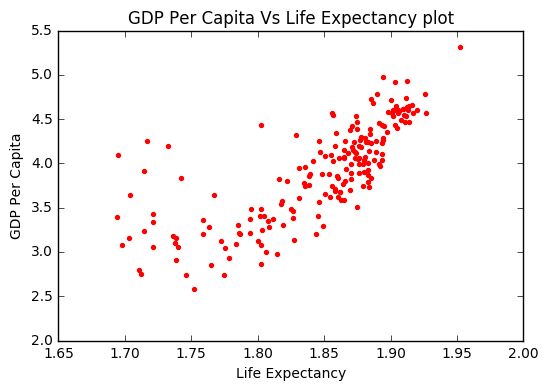

In [190]:
    Y1 = df['GDP (PPP) in US $']
    Y1 = np.log10(Y1/df['Population'])    
    X1 = np.log10(df['Life Expectancy'])
    plt.scatter(X1,Y1,color='red',s=8)
    plt.xlabel("Life Expectancy",fontsize=10); 
    plt.ylabel("GDP Per Capita", fontsize=10)
    _=plt.title("GDP Per Capita Vs Life Expectancy plot", fontsize=12)
    plt.show()



Analysis - We can see from the graph that GDP Per Capita is directly correlated to Life Expectancy. This is obvious as the countries 
with an higher average income can afford better living standards and health care , thereby increasing the life expectancy 

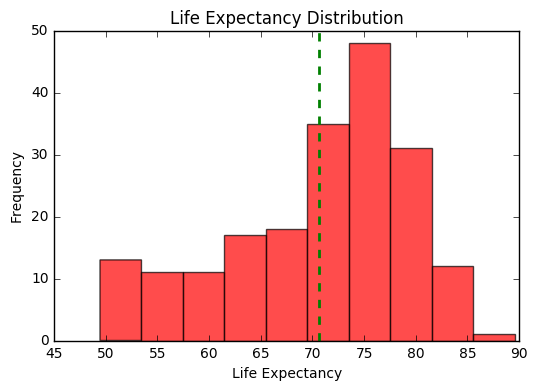

In [191]:
plt.xlabel("Life Expectancy",fontsize=10); 
plt.ylabel("Frequency", fontsize=10)
_=plt.title("Life Expectancy Distribution", fontsize=12)
X = df['Life Expectancy']
plt.axvline(X.mean(), color='green', linestyle='dashed', linewidth=2)
plt.hist(X,color='r', alpha=0.7, normed=False)
plt.show()

Analysis - We see from the graph that life expectancy between 70-80 yrs is prevalent in highest number of countries. life expectancy of 85-90 years is rare.  

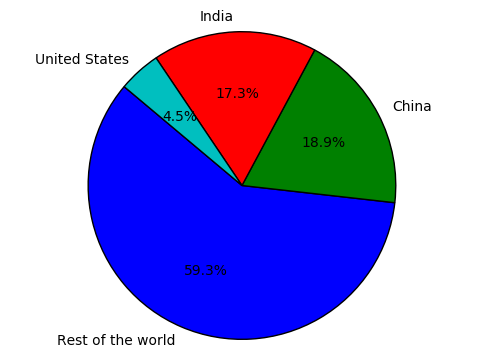

In [192]:
new_dataFrame = (pd.DataFrame.copy(df)).set_index('Country Name')
new_dataFrame = new_dataFrame.sort('Population',ascending=False)
new_dataFrame = pd.DataFrame(new_dataFrame['Population'])
population_RestofWorld = np.sum(new_dataFrame['Population']) - np.sum(new_dataFrame.iloc[0:3]['Population'])
new_dataFrame.loc['Rest of the world'] = population_RestofWorld
new_dataFrame.sort('Population',ascending=False,inplace=True)
new_dataFrame = new_dataFrame.iloc[0:4]
labels = new_dataFrame.index.values
sizes =  new_dataFrame['Population']

plt.pie(sizes, labels=labels,
        autopct='%1.1f%%', shadow=False, startangle=140)
 
plt.axis('equal')
plt.show()

Analysis - The top countries having maximum population consist of almost 40% chunk of the total population of the world. While India and China are close amongst top 3, USA is far behind. 

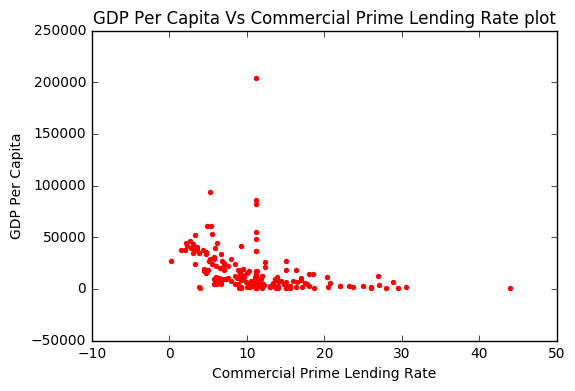

In [193]:
Y1 = df['GDP (PPP) in US $']
Y1 = (Y1/df['Population'])    
X1 = (df['Commercial Prime Lending Rate'])
plt.scatter(X1,Y1,color='red',s=8)
plt.xlabel("Commercial Prime Lending Rate",fontsize=10); 
plt.ylabel("GDP Per Capita", fontsize=10)
_=plt.title("GDP Per Capita Vs Commercial Prime Lending Rate plot", fontsize=12)
plt.show()




Analysis - We can fairly observe that GDP Per capita is negatively correlated with Lending rate. This is obvious because richer the country, lower will be its lending rate and higher will be its average income

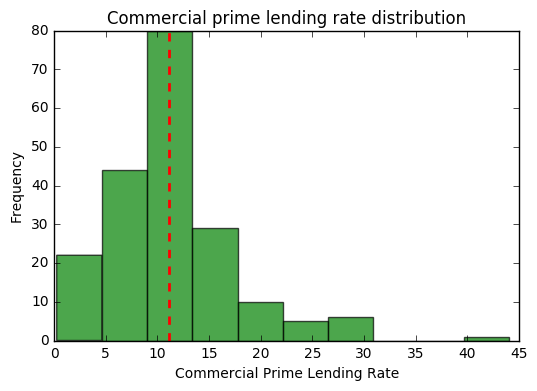

In [194]:
plt.xlabel("Commercial Prime Lending Rate",fontsize=10); 
plt.ylabel("Frequency", fontsize=10)
_=plt.title("Commercial prime lending rate distribution", fontsize=12)
X = df['Commercial Prime Lending Rate']
plt.axvline(X.mean(), color='red', linestyle='dashed', linewidth=2)
plt.hist(X,color='green', alpha=0.7, normed=False)
plt.show()

Analysis - Almost all of the countries have a Lending rate between 0-30%. Small number of extremely poor countries have a high lending rate of 40-45%. Almost half of the countries of the world have a lending rate between 10-15%

Next We plot a world map with different countries marked on it using basemaps.

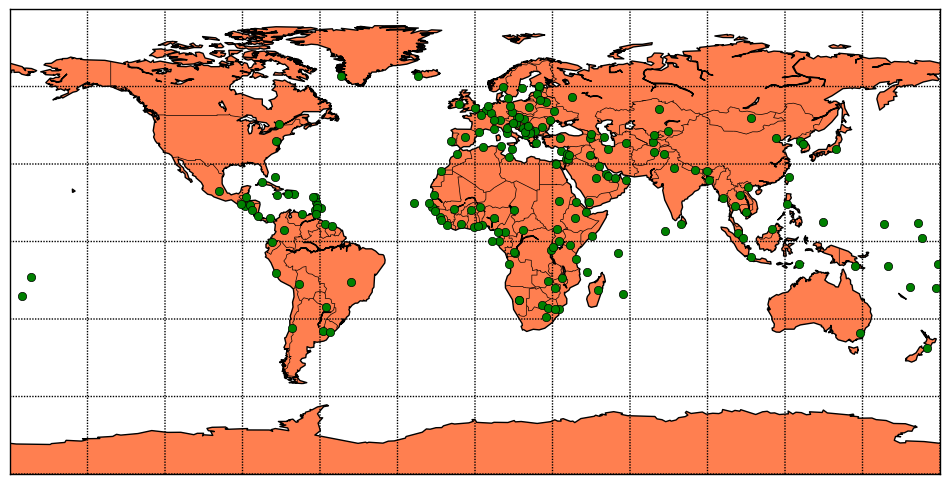

In [195]:
df['Latitude of Capital'][123] = '0 0 N'
df['Longitude of Capital'][123] = '0 0 N'

Country_latitudes = df['Latitude of Capital'].apply(str)
Country_longitudes = df['Longitude of Capital'].apply(str)

def convertLatitudeLongitude_ToDecimal(degrees, minutes,direction):
    a = float(degrees) + float(minutes)/60 
    if direction == 'E' or direction == 'N':
        a *= +1
    else :
        if direction == 'S' or direction == 'W':
            a *= -1
    return a;

def parse_Coordinates(a):    
    if a !='null':
        b = re.split(' ', a)        
        return (convertLatitudeLongitude_ToDecimal(b[0], b[1], b[2]))
    else :
        return 0

latitude=[]
longitude=[]
for lat in Country_latitudes:
    latitude.append(parse_Coordinates(lat))
for lon in Country_longitudes:
    longitude.append(parse_Coordinates(lon))    
    
plt.figure(figsize=(12,6))
#my_map = Basemap(projection='cyl', lat_0=0, lon_0=-200,
#              resolution='l', area_thresh=10000.0)
my_map = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,
            llcrnrlon=-180,urcrnrlon=180,resolution='c')
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color='coral')
my_map.drawmapboundary()
 
my_map.drawmeridians(np.arange(0, 360, 30))
my_map.drawparallels(np.arange(-90, 90, 30))


x,y = my_map(lond,latd)
my_map.plot(x, y, 'go', markersize=6)

 
plt.show()    

Q 2) Do a pairwise Pearson correlation analysis on all valid pairs of variables. Find out most positive and negative correlations. Do a permutation test to determine the p-values of these 2 correlations to test which are significant (what fraction of permutations produce at least this high a correlation). 

Ans - The correlation matrix for all numerical pairs of variables is as follows:

In [196]:
df.corr()

,Population,Life Expectancy,GDP (PPP) in US $,Area (sq km),Land Boundaries (km),Coastline (km),Literacy Rate (%),Health Expenditure/GDP,Military Expenditure/GDP,Renewable Water Resources (cu km),Net Migration Rate/1000 Population,Labor Force,Internet Users (circa 2009),Commercial Prime Lending Rate
Population,1.000000,0.014249,0.697699,0.453228,0.588406,0.120474,-0.042841,-0.070342,0.032555,0.428147,0.004437,0.980173,0.761488,-0.048634
Life Expectancy,0.014249,1.000000,0.175169,0.033022,-0.171602,0.162933,0.723925,0.117537,-0.053949,0.074657,0.132196,0.032018,0.151821,-0.441829
GDP (PPP) in US $,0.697699,0.175169,1.000000,0.592458,0.517516,0.204549,0.124516,0.193751,0.101264,0.472211,0.033247,0.730245,0.938982,-0.183511
Area (sq km),0.453228,0.033022,0.592458,1.000000,0.776411,0.521336,0.051362,0.064267,0.139683,0.753144,0.038319,0.476994,0.565220,-0.031600
Land Boundaries (km),0.588406,-0.171602,0.517516,0.776411,1.000000,0.223262,-0.097268,-0.103138,0.116610,0.677311,-0.034384,0.598773,0.546896,0.117924
Coastline (km),0.120474,0.162933,0.204549,0.521336,0.223262,1.000000,0.134779,0.108460,-0.038905,0.375393,0.041033,0.123811,0.175513,-0.140495
Literacy Rate (%),-0.042841,0.723925,0.124516,0.051362,-0.097268,0.134779,1.000000,0.120436,-0.094368,0.078604,0.046967,-0.010860,0.115658,-0.326571
Health Expenditure/GDP,-0.070342,0.117537,0.193751,0.064267,-0.103138,0.108460,0.120436,1.000000,-0.130821,0.055628,0.001128,-0.055996,0.139570,-0.115620
Military Expenditure/GDP,0.032555,-0.053949,0.101264,0.139683,0.116610,-0.038905,-0.094368,-0.130821,1.000000,0.030367,0.145864,0.030898,0.070630,-0.041771
Renewable Water Resources (cu km),0.428147,0.074657,0.472211,0.753144,0.677311,0.375393,0.078604,0.055628,0.030367,1.000000,0.004280,0.439960,0.477802,0.112432


Hence Commercial prime lending rate and Life expectancy are most negatively correlated (-0.441829). Similarly , we see Labor force and population are most highly correlated (0.980173)

Now , we do a permutation test on these 2 corelations to determine their p values. We do a random shuffling of one of the columns for 1000 iterations

In [197]:
 df_Pop_LaborForce = pd.concat([df['Population'], df['Labor Force']], axis=1, keys=['Population', 'Labor Force'])
 df_LendRate_Expectancy = pd.concat([df['Life Expectancy'], df['Commercial Prime Lending Rate']], axis=1, 
                                    keys=['Life Expectancy', 'Commercial Prime Lending Rate'])

In [198]:
def calculate_pvalue(df,n,column_name,real_corr_value):
    j=0
    for i in range(n):
        df[column_name] = np.random.permutation(df[column_name])
        c_value = np.min(df.corr())
        if real_corr_value >0:
            if c_value[0] >= real_corr_value:
                j = j+1
        else:
            if c_value[0] <= real_corr_value:
                j = j+1
    if j == 0:        
        return 1.0*1/n
    else:
        return 1.0*j/n
    

    

In [199]:
p_value_maxCorrelation = calculate_pvalue(df_Pop_LaborForce,1000,'Labor Force',0.980173)
p_value_maxCorrelation


0.001

In [200]:
p_value_minCorrelation = calculate_pvalue(df_LendRate_Expectancy,1000,'Commercial Prime Lending Rate',-0.441829)
p_value_minCorrelation

0.001

Hence, the permutation test value for both correlations is 0.001. 

Q3) Set up a simple linear regression model to predict the average income (GDP per capita) as a function of other individual variables. Among all options, which model minimizes the squared error? Under this model, which countries are most above the forecast?   Which are most below?   Can you explain why?
(Answer provided in HW2.json file)

Ans) For this question , we first add an extra column in our data frame called "GDP per Capita". which is the division of GDP by Population column. Next we plot linear regression graphs for GDP Per Capita with each of the other individual variables and calculate the mean squared error.

Since GDP per capita is a ratio of GDP by Population , we choose to evaluate linear regression model for all these variables on a log 10 scale.

 

In [201]:
df['GDP Per Capita'] = df['GDP (PPP) in US $']/df['Population']


In [202]:
def predict_countries(df,Target_Predictions):
    newFrame = pd.concat([df['Country Name'], df['GDP Per Capita']], axis=1, 
                         keys=['Country Name', 'GDP Per Capita'])
    newFrame['GDP Per Capita'] = np.log10(newFrame['GDP Per Capita'])
    newFrame['Target Predictions'] = Target_Predictions
    newFrame['Differences'] = newFrame['GDP Per Capita'] - newFrame['Target Predictions']
    newFrame.to_csv('out1.csv')
    newFrame.sort('Differences',ascending=False,inplace=True)
    newFrame.to_csv('out2.csv')
    MaxCountries_list = newFrame['Country Name'][0:3]
    newFrame.sort('Differences',ascending=True,inplace=True)
    newFrame.to_csv('out3.csv')
    MinCountries_list = newFrame['Country Name'][0:3]
    print ("3 countries most above the forecast:%s\n"%(MaxCountries_list).values)
    print ("3 countries most below the forecast:%s\n"%(MinCountries_list).values)

def Plot_LinearRegression(df,x_coordinate,y_coordinate):    
    X1 = df[x_coordinate]
    X1 = np.log10(X1)
    Y1 = df[y_coordinate]
    Y1 = np.log10(Y1)
    SimpleRegression_model = LinearRegression()
    SimpleRegression_model = SimpleRegression_model.fit(X1.reshape(len(X1),1),Y1)
    Target_Predictions = SimpleRegression_model.predict(X1.reshape(len(X1),1))        
    print("Residual sum of squares: %.2f"
      % np.sum((Target_Predictions - Y1) ** 2))    
    if x_coordinate == 'Life Expectancy':
        predict_countries(df,Target_Predictions)
    # plotting the graphs
    plt.plot(X1,Target_Predictions,color='Red',linewidth=2)
    plt.scatter(X1,Y1,color='m')
    plt.xlabel("log (%s)"%x_coordinate,fontsize=12); 
    plt.ylabel("log (%s)"%y_coordinate, fontsize=12)
    _=plt.title("%s vs %s"%(y_coordinate,x_coordinate), fontsize=12)
    plt.show()



Residual sum of squares: 56.94


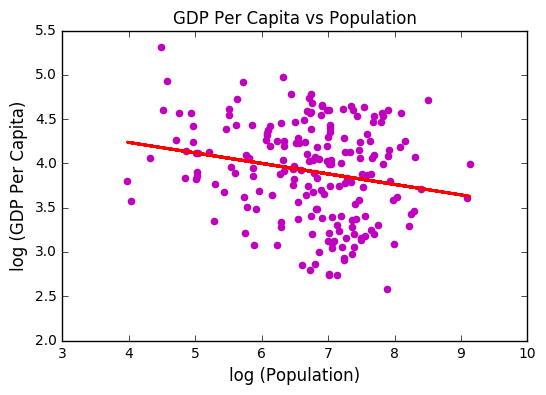

In [203]:
Plot_LinearRegression(df,'Population','GDP Per Capita')

Residual sum of squares: 24.52
3 countries most above the forecast:['Gabon' 'South Africa' 'Botswana']

3 countries most below the forecast:['Eritrea' 'Madagascar' 'Korea, North']



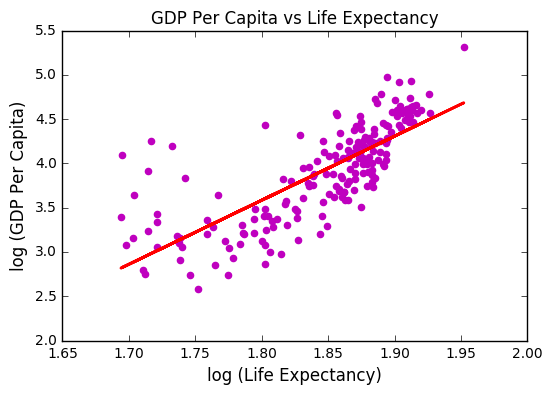

In [204]:
Plot_LinearRegression(df,'Life Expectancy','GDP Per Capita')

Residual sum of squares: 52.35


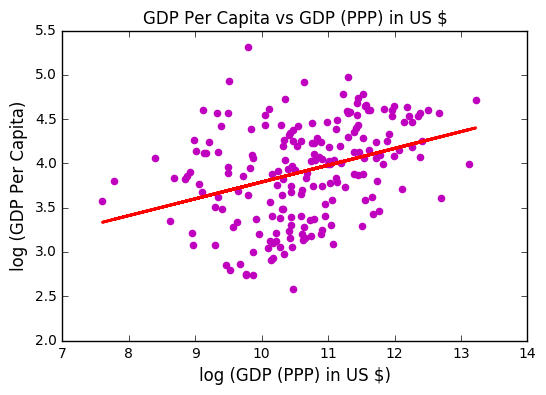

In [205]:
Plot_LinearRegression(df,'GDP (PPP) in US $','GDP Per Capita')

Residual sum of squares: 56.35


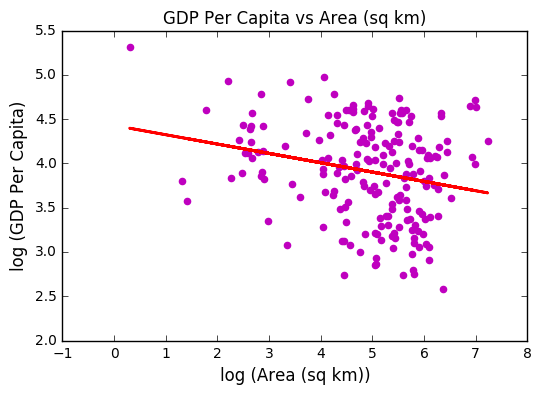

In [206]:
Plot_LinearRegression(df,'Area (sq km)','GDP Per Capita')

Residual sum of squares: 52.88


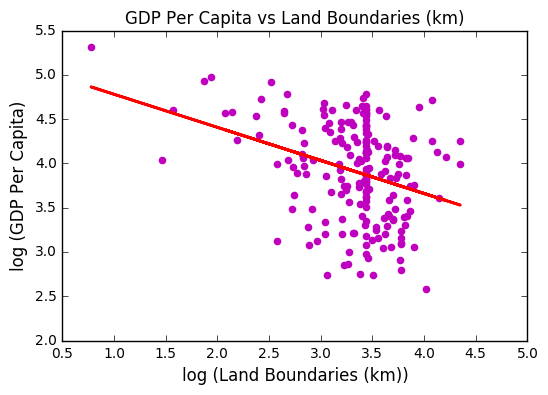

In [207]:
Plot_LinearRegression(df,'Land Boundaries (km)','GDP Per Capita')

Residual sum of squares: 56.39


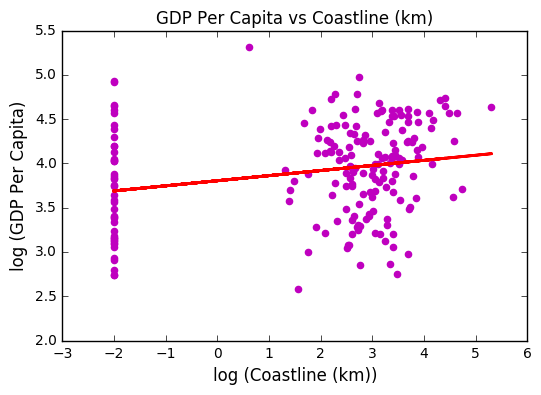

In [208]:
Plot_LinearRegression(df,'Coastline (km)','GDP Per Capita')

As we can see in the graph above, the values on x = -2 are for coastline 0 which we changed to 0.01 before.

Residual sum of squares: 32.09


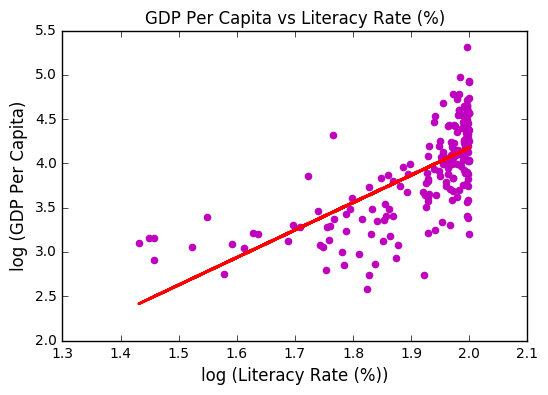

In [209]:
Plot_LinearRegression(df,'Literacy Rate (%)','GDP Per Capita')

From the graph , its clear that many countries are in the higher ranges of literacy rate (80-100%). 

Residual sum of squares: 59.24


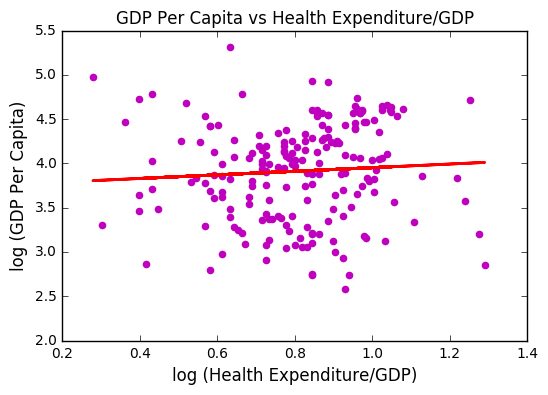

In [210]:
Plot_LinearRegression(df,'Health Expenditure/GDP','GDP Per Capita')

Residual sum of squares: 59.30


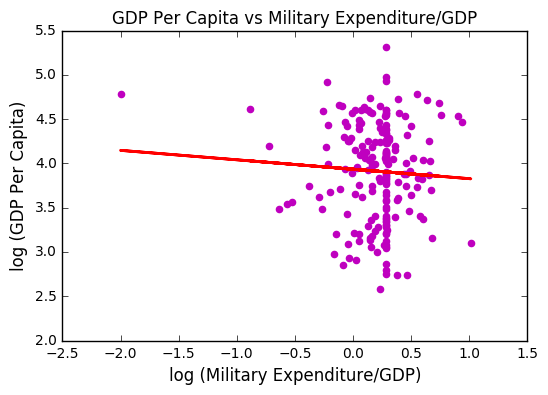

In [211]:
Plot_LinearRegression(df,'Military Expenditure/GDP','GDP Per Capita')


Residual sum of squares: 58.87


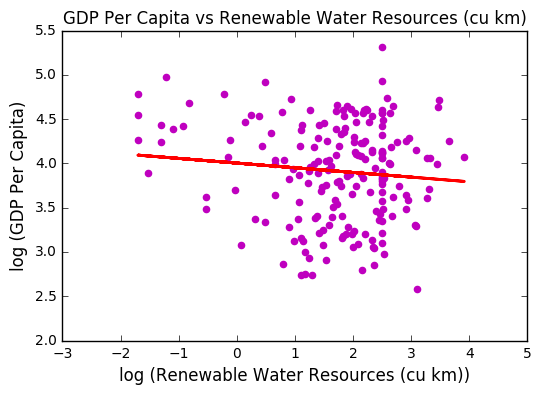

In [212]:
Plot_LinearRegression(df,'Renewable Water Resources (cu km)','GDP Per Capita')

Residual sum of squares: 57.99


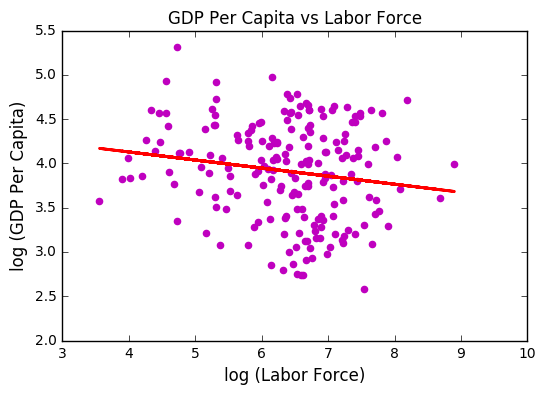

In [213]:
Plot_LinearRegression(df,'Labor Force','GDP Per Capita')

Residual sum of squares: 55.90


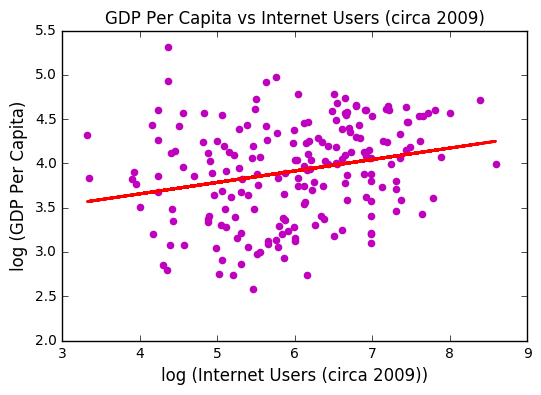

In [214]:
Plot_LinearRegression(df,'Internet Users (circa 2009)','GDP Per Capita')

Residual sum of squares: 41.51


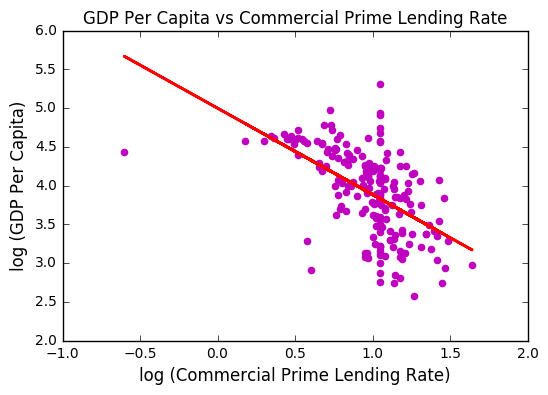

In [215]:
Plot_LinearRegression(df,'Commercial Prime Lending Rate','GDP Per Capita')

Hence , among all the models , GDP Per Capita vs Life Expectancy has the least squared error (24.52). 3 countries that are most above the forecast are - Gabon, South Africa and Botswana.
3 countries most below the forecast are Eritrea, Madagascar and North Korea. This may be possibly due to large difference of Life Expectancy of these countries compared to their neighbours.


Q4) Set up a scoring/ranking function to measure general social welfare ?. Which countries do best and worst by your measure ? Write a few paragraphs to describe your measure and evaluate how good/bad you think the results are.

Ans - We take into consideration features that are strong positive and negative indicators of welfare of a country. 
In my opinion Life Expectancy, GDP Per Capita and Literacy Rate are strong positive indicator whereas Lending rate is a negative indicator.  

We then assign credits to each factor based on their strength. We sum up and average the scores of each positive and negative indicator and calculate an overall welfare score for each country .Results are heighlighted below 

In [216]:
scoreFrame = (pd.DataFrame.copy(df)).set_index('Country Name')
array_to_del =['Country Code','Government Type','Capital City','Date of Founding/Independence','Latitude of Capital',
               'Longitude of Capital','Population','GDP (PPP) in US $','Area (sq km)','Land Boundaries (km)',
               'Coastline (km)','Health Expenditure/GDP','Military Expenditure/GDP','Renewable Water Resources (cu km)',
               'Net Migration Rate/1000 Population','Labor Force','Internet Users (circa 2009)']

for col in scoreFrame.columns:
    if col in array_to_del:
        del scoreFrame[col]

scoreFrame.rename(columns = {'Life Expectancy':'Life Expectancy score','Literacy Rate (%)':
                             'Literacy Rate Score','Commercial Prime Lending Rate':'Commercial Prime Lending Rate score',
                            'GDP Per Capita':'GDP Per Capita score'}, inplace = True)

def Calculate_Column_scores(column_name):
    scoreFrame[column_name] = (scoreFrame[column_name]/max(scoreFrame[column_name]))*100
    if column_name == 'Commercial Prime Lending Rate score':
        scoreFrame[column_name] = -scoreFrame[column_name]
        

Calculate_Column_scores('Life Expectancy score')
Calculate_Column_scores('Literacy Rate Score')
Calculate_Column_scores('Commercial Prime Lending Rate score')
Calculate_Column_scores('GDP Per Capita score')
    
scoreFrame['Country Welfare Score'] = (((4*scoreFrame['Life Expectancy score']) + 
                                        (4*scoreFrame['GDP Per Capita score'])+
                                      (3*scoreFrame['Literacy Rate Score']) + 
                                     (3*scoreFrame['Commercial Prime Lending Rate score']))/14.0)  

scoreFrame.sort('Country Welfare Score',ascending=False,inplace=True)
scoreFrame['Rank'] = np.arange(1,198)
scoreFrame.head(5)

,Life Expectancy score,Literacy Rate Score,Commercial Prime Lending Rate score,GDP Per Capita score,Country Welfare Score,Rank
Country Name,,,,,,
Monaco,100.000000,99.0,-25.258488,100.000000,72.944610,1
Qatar,87.506978,96.3,-12.045455,46.023828,56.206204,2
Liechtenstein,91.191247,100.0,-25.258488,42.111644,54.102578,3
Singapore,94.205649,95.9,-12.227273,29.899738,53.388552,4
Luxembourg,89.326784,100.0,-25.258488,40.241189,53.035459,5


In [217]:
scoreFrame.tail(5)

,Life Expectancy score,Literacy Rate Score,Commercial Prime Lending Rate score,GDP Per Capita score,Country Welfare Score,Rank
Country Name,,,,,,
"Gambia, The",71.854416,51.1,-69.318182,0.937939,16.893919,193
Chad,55.197053,35.4,-35.227273,1.204771,16.151820,194
Guinea,66.540136,41.0,-59.090909,0.537493,15.288413,195
Afghanistan,56.369320,28.1,-34.090909,0.698991,15.021465,196
Madagascar,72.792230,64.5,-100.000000,0.466233,13.323846,197


Our results are satisfying when compared with wikipedia rankings (List of countries by Sen social welfare function). 14 countries out of the top 20 and 13 countries out of the lowest 20 in our list match with Sen's list.  

Q5) Set up a meaningful distance function to measure how similar/difference pairs of countries are.Produce a table showing the nearest and farthest neighbor to each nation on earth?   
Write a short analysis of this table describing: (a) What  kinds of similarities does your measure get right?   (b) What are the most interesting/surprising pairs to fall out of this analysis?  and (c) Where does it goof up?


Ans - We consider Life Expectancy, GDP, Literacy Rate and Lending rate as the factors to determine similarities of countries

In [218]:
feature_Matrix =(df[['Life Expectancy','GDP (PPP) in US $','Literacy Rate (%)','Commercial Prime Lending Rate',
                     'Net Migration Rate/1000 Population']])

feature_Matrix_norm = (feature_Matrix - feature_Matrix.mean()) / (feature_Matrix.max() - feature_Matrix.min())
distances = pdist(feature_Matrix_norm.values, metric='euclidean')
Distance_Matrix = squareform(distances)
country_frame = df['Country Name']
Distance_Matrix = pd.DataFrame(Distance_Matrix) 
Distance_Matrix = pd.concat([df['Country Name'], Distance_Matrix], axis=1).set_index('Country Name')

for i in range(197):
    Distance_Matrix.rename(columns={i:df['Country Name'][i]},inplace = True)
    
Final_Matrix_Farthest = Distance_Matrix.idxmax(axis=0)
Final_Matrix_Farthest = pd.DataFrame(Final_Matrix_Farthest)
for i in range(197):
    Distance_Matrix.iloc[i][i] = np.nan

Final_Matrix_Nearest = Distance_Matrix.idxmin(axis=0)
Final_Matrix_Nearest = pd.DataFrame(Final_Matrix_Nearest)

Final_Matrix = pd.concat([Final_Matrix_Farthest[0], Final_Matrix_Nearest[0]], axis=1, keys=['Farthest Neighbour', 
                        'Nearest Neighbour'])


In [219]:
Final_Matrix.head(10)

,Farthest Neighbour,Nearest Neighbour
Afghanistan,United States,Chad
Albania,Afghanistan,Chile
Algeria,United States,Morocco
Andorra,Afghanistan,Liechtenstein
Angola,United States,Cameroon
Antigua and Barbuda,Afghanistan,Croatia
Argentina,Afghanistan,Venezuela
Armenia,Afghanistan,Azerbaijan
Australia,Afghanistan,Spain
Austria,Afghanistan,Ireland


In [220]:
Final_Matrix.tail(10) 

,Farthest Neighbour,Nearest Neighbour
United States,Afghanistan,China
Uruguay,Afghanistan,Antigua and Barbuda
Uzbekistan,Afghanistan,Belarus
Vanuatu,United States,Iraq
Venezuela,Afghanistan,Turkey
Vietnam,Afghanistan,Palau
Western Sahara,United States,Kiribati
Yemen,United States,Laos
Zambia,United States,Nigeria
Zimbabwe,United States,Malawi


Analysis - Many of the countries that we see here in nearest neighbours make sense. For example Zimbabwe and Malawi, Armenia and Azerbaijan ,Bangladesh and Bhutan, Belgium and Ireland, Canada and France, etc . These countries are indeed close to each other. 

However, in terms of farthest neighbours , we see mostly Afghanistan and United States as being the farthest to all other countries. This is surprising . Clearly , some data is skewed as one of the parameters is causing heavy impact and over shadowing the rest of the parameters